In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [4]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
df = pd.read_csv("train.csv")
print("Dataset shape:", df.shape)
print("\nMissing values per column:\n", df.isna().sum())
df.head()

Dataset shape: (891, 12)

Missing values per column:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
target = 'Survived'

X = df[features].copy()
y = df[target]


num_features = ['Age', 'SibSp', 'Parch', 'Fare']
cat_features = ['Sex', 'Embarked']


num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])


X_pre = preprocessor.fit_transform(X)

print("Preprocessed data shape:", X_pre.shape)


Preprocessed data shape: (891, 9)


In [6]:
# --- Q2: Fine-tune Decision Tree ---

dt = DecisionTreeClassifier(random_state=42)


param_grid_dt = {
    'max_depth': [2, 3, 4, 5, 6, 8, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


gs_dt = GridSearchCV(dt, param_grid_dt, cv=cv, scoring='accuracy', n_jobs=-1)
gs_dt.fit(X_pre, y)

best_dt = gs_dt.best_estimator_
print("Best Decision Tree parameters:", gs_dt.best_params_)
print("Best cross-validation accuracy:", gs_dt.best_score_)


Best Decision Tree parameters: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best cross-validation accuracy: 0.8204130311970372


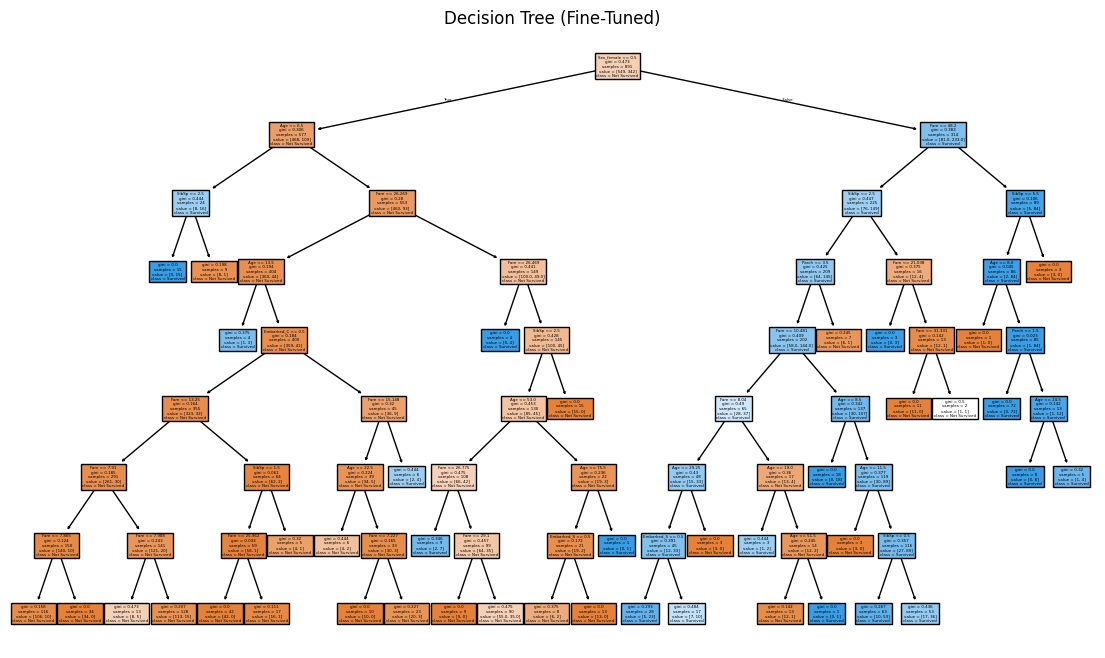

In [7]:

cat_names = list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(cat_features))
feature_names = num_features + cat_names

plt.figure(figsize=(14, 8))
plot_tree(best_dt, feature_names=feature_names, class_names=['Not Survived', 'Survived'], filled=True)
plt.title("Decision Tree (Fine-Tuned)")
plt.show()


In [8]:
# --- Q3: 5-Fold CV for Decision Tree ---

cv_scores_dt = cross_val_score(best_dt, X_pre, y, cv=cv, scoring='accuracy')
print("Decision Tree 5-fold CV accuracies:", np.round(cv_scores_dt, 4))
print("Decision Tree mean CV accuracy:", cv_scores_dt.mean())


Decision Tree 5-fold CV accuracies: [0.8324 0.8034 0.7978 0.8258 0.8427]
Decision Tree mean CV accuracy: 0.8204130311970372


In [9]:
# --- Q4: 5-Fold CV for Random Forest ---

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [4, 6, 8, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

gs_rf = GridSearchCV(rf, param_grid_rf, cv=cv, scoring='accuracy', n_jobs=-1)
gs_rf.fit(X_pre, y)

best_rf = gs_rf.best_estimator_
print("Best Random Forest parameters:", gs_rf.best_params_)
print("Best cross-validation accuracy:", gs_rf.best_score_)


cv_scores_rf = cross_val_score(best_rf, X_pre, y, cv=cv, scoring='accuracy')
print("Random Forest 5-fold CV accuracies:", np.round(cv_scores_rf, 4))
print("Random Forest mean CV accuracy:", cv_scores_rf.mean())


Best Random Forest parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation accuracy: 0.8350009415604797
Random Forest 5-fold CV accuracies: [0.8492 0.8315 0.809  0.8315 0.8539]
Random Forest mean CV accuracy: 0.8350009415604797


In [11]:

print(f"Decision Tree mean CV accuracy: {cv_scores_dt.mean():.4f}")
print(f"Random Forest mean CV accuracy: {cv_scores_rf.mean():.4f}")

if cv_scores_rf.mean() > cv_scores_dt.mean():
    print("\n Random Forest performs better on average than Decision Tree.")
else:
    print("\n Decision Tree performs better or similarly on average.")

print("""
Observations:
- Decision Tree is simpler and interpretable but may overfit.
- Random Forest averages many trees, reducing variance and improving accuracy.
- Therefore, Random Forest generally generalizes better on unseen data.
""")


Decision Tree mean CV accuracy: 0.8204
Random Forest mean CV accuracy: 0.8350

 Random Forest performs better on average than Decision Tree.

Observations:
- Decision Tree is simpler and interpretable but may overfit.
- Random Forest averages many trees, reducing variance and improving accuracy.
- Therefore, Random Forest generally generalizes better on unseen data.

